# IRIS DATA CLASSIFICATION

This notebook trains neural network to classify iris data. The training manifesto given in the notebook follows the caviar search strategy for hyperparameter tuning, a technique is followed by machine learning scientists and engineers for training deep learning models.

**Import deep_learn package**

In [1]:
try:
    from deep_learn.nn import ann
except:
    from config import *
    append_path('../')
    from deep_learn.nn import ann

**Import neccessary package**

In [2]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

## 1. Load and reshape data

**Load iris data**

In [3]:
iris = datasets.load_iris()

In [4]:
X = iris.data
y = iris.target.reshape(-1,1)

**Store the data in pandas dataframe**

In [5]:
# stack the X y data horizontally
data = np.hstack((X,y))
# store the numpy array in pandas dataframe
data = pd.DataFrame(data=data, columns=iris.feature_names +['species'])
# shuffle the data
data = data.sample(frac=1, random_state=1).reset_index(drop=True)

In [6]:
data.head(20)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.8,4.0,1.2,0.2,0.0
1,5.1,2.5,3.0,1.1,1.0
2,6.6,3.0,4.4,1.4,1.0
3,5.4,3.9,1.3,0.4,0.0
4,7.9,3.8,6.4,2.0,2.0
5,6.3,3.3,4.7,1.6,1.0
6,6.9,3.1,5.1,2.3,2.0
7,5.1,3.8,1.9,0.4,0.0
8,4.7,3.2,1.6,0.2,0.0
9,6.9,3.2,5.7,2.3,2.0


**Features and output of the data**

In [7]:
features = iris.feature_names
output = 'species'

## 2. Preprocess the data for deep learning model

`Note:` I did not use a separate validation set in this excercise since the iris data only contains 150 examples. It is difficult to split such a small data into train, validation, and test sets. According to literature it is ok to leave out the validation set in such case. For such a small data K fold cross validation is a viable option; but K fold cross validation is used for normal machine learning algorithms, not deep learning algorithms. Deep learning algorithms works best in the big data regime, training deep learning models takes more time than training normal machine learning models. Hence, engineers do not use K fold cross validation for training deep learning models.

**Do a train test split**

In [8]:
train_data, test_data = train_test_split(data, test_size = 0.266, random_state = 1)

**A function to extract feature matrix and output vector**

In [9]:
def get_xy_data(dataframe, features = None, output = None):

    '''a function for parsing the feature matrix and output array from a pandas dataframe'''

    # to ignore pandas warning
    import warnings
    warnings.filterwarnings('ignore')

    # import numpy
    import numpy as np

    # if no featues are given then just return the a numpy matrix of the dataframe
    if features == None:
        return dataframe.as_matrix()

    # extract the feature matrix and convert it to numpy array
    X = dataframe[features].as_matrix()

    # if there is no output
    if output == None:
        return X
    # if the output vector is wanted by the user
    else:
        # extracting the output columns and converting it to numpy array
        y = dataframe[output].as_matrix()
        y = np.reshape(y, (-1,1))
        # returning the feature matrix and output vector
        return (X, y)

**Extract X y data for train and test set**

In [10]:
X_train, Y_train = get_xy_data(train_data, features=features, output=output)
X_test, Y_test = get_xy_data(test_data, features=features, output=output)

**Onehot encoding the y data**

In [11]:
encoder = OneHotEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_train = Y_train.toarray()
Y_test = encoder.transform(Y_test)
Y_test = Y_test.toarray()

In [12]:
print(X_train.shape)
print(Y_train.shape)

(110, 4)
(110, 3)


In [13]:
print(X_test.shape)
print(Y_test.shape)

(40, 4)
(40, 3)


## 3. Train the first neural network for classification

Implementation of first neural network is a dirty implementation which allows engineers to test if the network along with its hyperparameters, architecture, loss function actually works. After creating dirty implementation engineers do hyperparameter tuning. Now the iris dataset for is a very simple data to create a very accurate first implementation. Things will not so easy for example creating a yolo object detection network for detecting vehicles, pedestrians, and road signs for self driving system.  

**Neural network architecture**

In [14]:
layers_dims = [4,4,8,8,4,3]

**Create a nn model object**

In [15]:
model = ann(layers_dims=layers_dims)

**Hyperparameters of the model**

In [16]:
batch_size = X_train.shape[0]
learning_rate = 0.1*.5
num_iterations = 40000

**Fit the model**

In [17]:
model.fit(X_train, Y_train, X_test, Y_test, batch_size,
          learning_rate = learning_rate, 
          num_iterations = num_iterations, print_cost=True, random_seed = 0)

Cost after iteration 0: 1.141538
Cost after iteration 100: 1.097231
Cost after iteration 200: 1.101953
Cost after iteration 300: 1.097959
Cost after iteration 400: 1.095068
Cost after iteration 500: 1.095910
Cost after iteration 600: 1.096005
Cost after iteration 700: 1.098199
Cost after iteration 800: 1.102550
Cost after iteration 900: 1.099853
Cost after iteration 1000: 1.095382
Cost after iteration 1100: 1.099318
Cost after iteration 1200: 1.088701
Cost after iteration 1300: 1.095299
Cost after iteration 1400: 1.096558
Cost after iteration 1500: 1.096727
Cost after iteration 1600: 1.098543
Cost after iteration 1700: 1.099408
Cost after iteration 1800: 1.101593
Cost after iteration 1900: 1.097817
Cost after iteration 2000: 1.098948
Cost after iteration 2100: 1.099111
Cost after iteration 2200: 1.097732
Cost after iteration 2300: 1.097172
Cost after iteration 2400: 1.094945
Cost after iteration 2500: 1.096410
Cost after iteration 2600: 1.095079
Cost after iteration 2700: 1.092685
Cost

Cost after iteration 22600: 0.027459
Cost after iteration 22700: 0.083282
Cost after iteration 22800: 0.050851
Cost after iteration 22900: 0.044547
Cost after iteration 23000: 0.057898
Cost after iteration 23100: 0.077795
Cost after iteration 23200: 0.013936
Cost after iteration 23300: 0.055414
Cost after iteration 23400: 0.124773
Cost after iteration 23500: 0.066637
Cost after iteration 23600: 0.056938
Cost after iteration 23700: 0.050754
Cost after iteration 23800: 0.018727
Cost after iteration 23900: 0.084728
Cost after iteration 24000: 0.052523
Cost after iteration 24100: 0.115389
Cost after iteration 24200: 0.116157
Cost after iteration 24300: 0.083357
Cost after iteration 24400: 0.016763
Cost after iteration 24500: 0.092948
Cost after iteration 24600: 0.044386
Cost after iteration 24700: 0.112470
Cost after iteration 24800: 0.137813
Cost after iteration 24900: 0.075653
Cost after iteration 25000: 0.051496
Cost after iteration 25100: 0.079519
Cost after iteration 25200: 0.021277
C

**Plot of Cost vs Iteration**

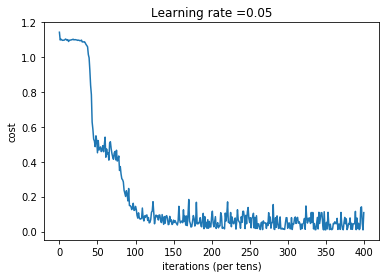

In [18]:
# plot the cost
plt.plot(np.squeeze(model.costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

## 3.Caviar Strategy for hyperparameter tuning

There are 2 strategies for deep learning hyperparamter tuning: 1) Panda strategy in which we babysit a single model, this is applicable if computing resource is limited 2) Caviar strategy in which we randomly initialize a number of hyperparameter settings and train neural network model using different settings and then choose the one with the lowest error, this is strategy is applicable if we have enormous computing resource. In this notebook I will choose to tune the parameters of learning rate and nn architecture using caviar strategy.

**Function to generate a given number of nn architectures**

In [19]:
def hidden_layer_and_node_generator(model_num, num_input, num_output, randome_seed = 0, low = 8, high=17):
    
    '''a function to generate a given number of nn architectures'''
    
    # set the random seed
    np.random.seed(randome_seed)
    
    # list to store the architectures
    model_architecture_list = []
    
    # iterate given number of times
    for i in range(model_num):
        # randomly generate number of hidden layers
        num_hidden = np.random.randint(low = 3, high = 6)
        # randomly generate the number of nodes in each layer
        layers_dims = np.random.randint(low = low, high = high, size = num_hidden)
        layers_dims = layers_dims.tolist()
        # insert the input and output layer
        layers_dims.insert(0,num_input)
        layers_dims.append(num_output)
        # append the architecture to the designated list
        model_architecture_list.append(layers_dims)
    
    return model_architecture_list

**Generaty a list of learning rates to choose from**

In [20]:
learning_rates = np.round(np.linspace(0.1*0.5,0.1*5,num=200),4)
learning_rates

array([0.05  , 0.0523, 0.0545, 0.0568, 0.059 , 0.0613, 0.0636, 0.0658,
       0.0681, 0.0704, 0.0726, 0.0749, 0.0771, 0.0794, 0.0817, 0.0839,
       0.0862, 0.0884, 0.0907, 0.093 , 0.0952, 0.0975, 0.0997, 0.102 ,
       0.1043, 0.1065, 0.1088, 0.1111, 0.1133, 0.1156, 0.1178, 0.1201,
       0.1224, 0.1246, 0.1269, 0.1291, 0.1314, 0.1337, 0.1359, 0.1382,
       0.1405, 0.1427, 0.145 , 0.1472, 0.1495, 0.1518, 0.154 , 0.1563,
       0.1585, 0.1608, 0.1631, 0.1653, 0.1676, 0.1698, 0.1721, 0.1744,
       0.1766, 0.1789, 0.1812, 0.1834, 0.1857, 0.1879, 0.1902, 0.1925,
       0.1947, 0.197 , 0.1992, 0.2015, 0.2038, 0.206 , 0.2083, 0.2106,
       0.2128, 0.2151, 0.2173, 0.2196, 0.2219, 0.2241, 0.2264, 0.2286,
       0.2309, 0.2332, 0.2354, 0.2377, 0.2399, 0.2422, 0.2445, 0.2467,
       0.249 , 0.2513, 0.2535, 0.2558, 0.258 , 0.2603, 0.2626, 0.2648,
       0.2671, 0.2693, 0.2716, 0.2739, 0.2761, 0.2784, 0.2807, 0.2829,
       0.2852, 0.2874, 0.2897, 0.292 , 0.2942, 0.2965, 0.2987, 0.301 ,
      

**Function to randomly generate a given number of learning rates**

In [21]:
def learning_rate_generator(learning_rates, model_num, randome_seed = 0):
    
    '''a function to randomly generate a given number of learning rates'''
    
    np.random.seed(randome_seed)
    
    return np.random.choice(learning_rates, size=model_num).tolist()

**Function which implements a caviar strategy search**

In [22]:
def caviar_strategy_search(model_num, batch_size, model_directory, randome_seed = 0, num_iterations = 40000):
    
    '''a function which implements a caviar strategy search'''
    
    # randomly generate a list of learning rates
    learning_rate_list = learning_rate_generator(learning_rates, model_num, randome_seed = randome_seed)
    # randomly generate a list of architectures 
    model_architecture_list = hidden_layer_and_node_generator(model_num,4,3, randome_seed = randome_seed)
    # lists to store the costs and accuracy of models
    cost_list = []
    accuracy_list = []
    
    # iterate a given number of times
    for i in range(model_num):
        # create and fit a nn model with given architecture
        model = ann(layers_dims=model_architecture_list[i])
        model.fit(X_train, Y_train, X_test, Y_test, batch_size,
                  learning_rate = learning_rate_list[i], 
                  num_iterations = num_iterations, print_cost=False, random_seed = randome_seed)
        
        #pickling the model
        pickle_out = open(model_directory+"iris_model_"+str(i+1)+".mdl","wb")
        pickle.dump(model, pickle_out)
        pickle_out.close()
        
        # append the average of last 5 costs to the designated list
        cost_list.append(np.average(model.costs[-5:]))
        # append the accuracy to the designated list
        accuracy_list.append(model.accuracy)
        
        # print statement
        print("Completed training and collected results for the model:",str(i+1))
        
    return model_architecture_list, learning_rate_list, cost_list, accuracy_list

**Do a caviar strategy search of hyperparameters**

In [23]:
# number of models
model_num = 20
# batch size
batch_size = X_train.shape[0]
# random seed
randome_seed = 0

In [24]:
model_architecture_list, learning_rate_list, cost_list, accuracy_list = \
caviar_strategy_search(model_num, batch_size, './iris_models/',randome_seed = randome_seed)

Completed training and collected results for the model: 1
Completed training and collected results for the model: 2
Completed training and collected results for the model: 3
Completed training and collected results for the model: 4
Completed training and collected results for the model: 5
Completed training and collected results for the model: 6
Completed training and collected results for the model: 7
Completed training and collected results for the model: 8
Completed training and collected results for the model: 9
Completed training and collected results for the model: 10
Completed training and collected results for the model: 11
Completed training and collected results for the model: 12
Completed training and collected results for the model: 13
Completed training and collected results for the model: 14
Completed training and collected results for the model: 15
Completed training and collected results for the model: 16
Completed training and collected results for the model: 17
Comple

**Store the results in pandas dataframe**

In [25]:
results = pd.DataFrame({"model layers": model_architecture_list,
                        "learning rate": learning_rate_list,
                        "accuracy": accuracy_list,
                        "cost": cost_list})
results = results.reindex(columns=["model layers", "learning rate", "accuracy", "cost"])

**Show the results**

In [26]:
results

,model layers,learning rate,accuracy,cost
0,"[4, 13, 8, 11, 3]",0.4389,0.950,0.066512
1,"[4, 11, 13, 10, 12, 3]",0.1563,0.975,0.022759
2,"[4, 16, 16, 9, 14, 15, 3]",0.3146,0.975,0.018037
3,"[4, 16, 9, 13, 16, 12, 3]",0.4842,0.975,0.029429
4,"[4, 11, 13, 8, 3]",0.2015,0.950,0.035190
5,"[4, 11, 16, 9, 11, 11, 3]",0.4910,0.975,0.062448
6,"[4, 15, 8, 9, 8, 12, 3]",0.2829,0.925,0.014656
7,"[4, 10, 15, 10, 8, 8, 3]",0.0704,0.975,0.037708
8,"[4, 13, 13, 14, 3]",0.0975,0.975,0.026099
9,"[4, 12, 9, 12, 3]",0.1314,0.975,0.020050


## 4. Conclusion

I used caviar search strategy to tune just 2 parameters beaucse my neural network class is limited. However, this strategy can be used to tune other hyperparameters like activation function, dropout probability, regularization lamba parameter, and others. Engineers dont use grid search for hyperparameter tuning for deep learning models; the reason is it sometimes takes days and weeks to train a deep learning model, a grid search is just not feasible; hence random search through hypermeter space is the most effective strategy, this is what caviar strategy does. The caviar search strategy has been encouraged by deep learning scientists like Andrew Ng and Ian Goodfellow.